In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

from keras import regularizers, optimizers
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential,load_model
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

from tensorflow.keras.callbacks import History,EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError as rmse

from scripts_ import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("modelling_data.csv")


countries,scaler  = general_data_prep(data,shift=14)

cols_not = ['total_cases_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'reproduction_rate',
       'new_tests_per_thousand', 'positive_rate', 'tests_per_case',]

del countries["germany"]
for country in countries.keys():
    countries[country] = countries[country]

X_train,X_test,y_train,y_test = prep_sequences(countries,cols_not,"hosp_patients_per_million")

Index(['total_cases_per_million', 'new_cases_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'reproduction_rate', 'hosp_patients_per_million',
       'new_tests_per_thousand', 'positive_rate', 'tests_per_case',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy',
       'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people',
       'mobility_recreation', 'mobility_grocery', 'mobility_parks',
       'mobility_t

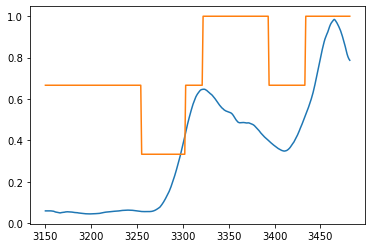

In [3]:
plt.plot(countries["poland"].hosp_patients_per_million)
plt.plot(countries["poland"]["C1_School closing"])

In [4]:
X_train.shape

(2243, 90, 30)

In [5]:
model = Sequential()

model.add(LSTM(256,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0))


model.add(LSTM(256))
model.add(Activation("relu"))
model.add(Dropout(0))


model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0))


model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0))



model.add(Dense(1,activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 256)           293888    
_________________________________________________________________
activation (Activation)      (None, 90, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [6]:
history = History()
Adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
early_s = EarlyStopping(monitor = "val_loss",patience = 6)
model.compile(loss="mse",optimizer=Adam,metrics=[rmse()])

In [7]:
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=30,batch_size=64,callbacks=[history,early_s])

Epoch 1/30
36/36 [==============================] - 24s 575ms/step - loss: 0.0339 - root_mean_squared_error: 0.1816 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 2/30
36/36 [==============================] - 18s 510ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 3/30
36/36 [==============================] - 19s 515ms/step - loss: 9.0469e-04 - root_mean_squared_error: 0.0300 - val_loss: 3.8055e-04 - val_root_mean_squared_error: 0.0195
Epoch 4/30
36/36 [==============================] - 19s 516ms/step - loss: 2.5317e-04 - root_mean_squared_error: 0.0159 - val_loss: 4.9196e-04 - val_root_mean_squared_error: 0.0222
Epoch 5/30
36/36 [==============================] - 19s 539ms/step - loss: 2.8514e-04 - root_mean_squared_error: 0.0167 - val_loss: 1.8273e-04 - val_root_mean_squared_error: 0.0135
Epoch 6/30
36/36 [==============================] - 20s 561ms/step - loss: 1.4507e-04 - root_mean_squared_error

In [10]:
model.save("hosp_model.keras")

In [8]:
reverse_scaler = MinMaxScaler()
reverse_scaler.min_,reverse_scaler.scale_ = scaler.min_[5], scaler.scale_[5]

COUNTRY: belgium


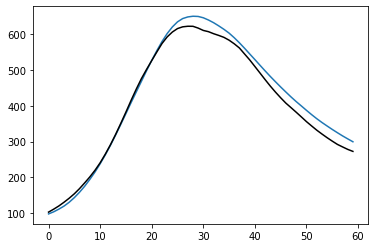

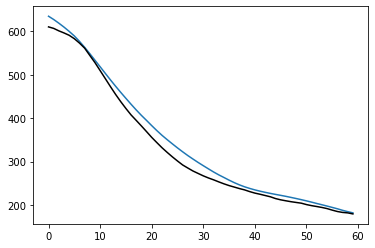

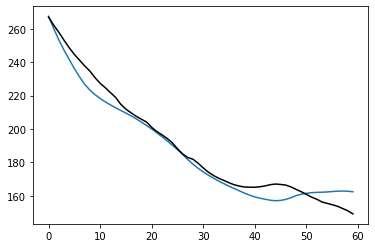

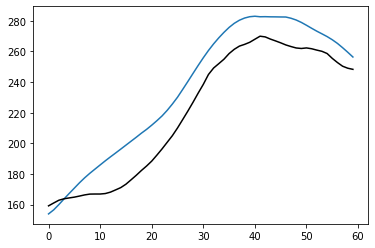

COUNTRY: france


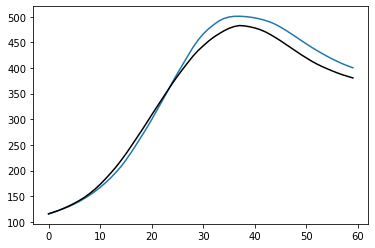

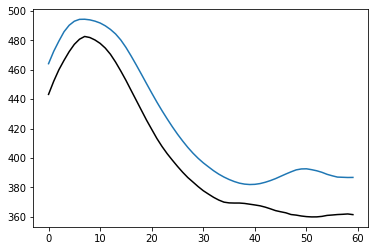

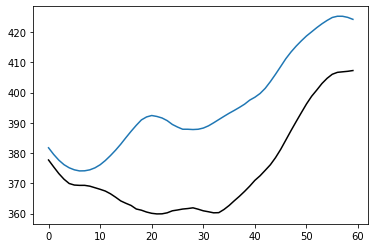

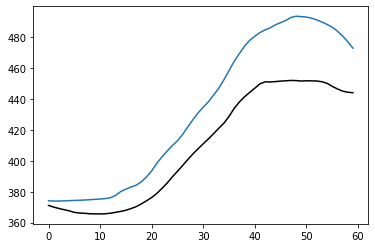

COUNTRY: israel


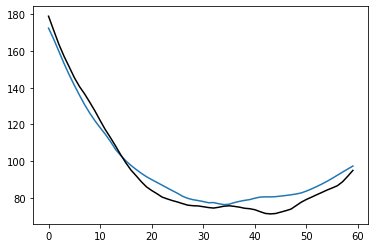

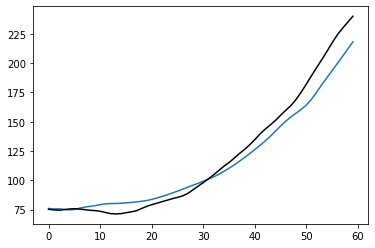

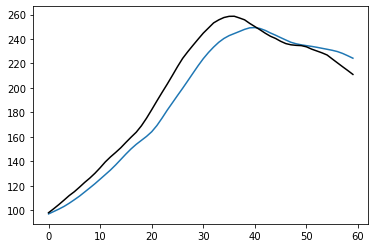

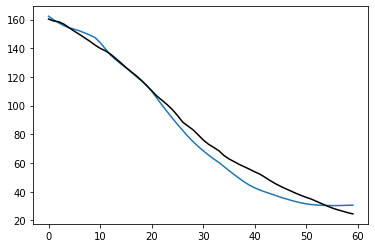

COUNTRY: italy


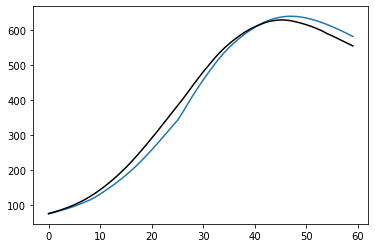

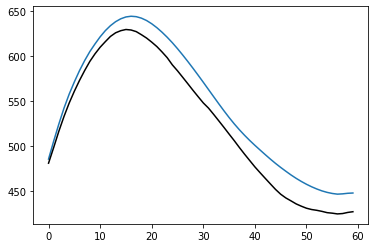

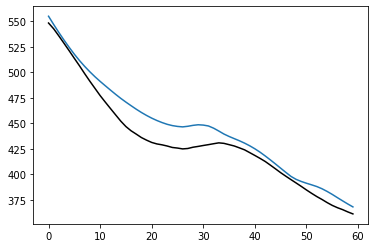

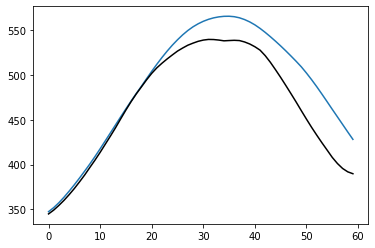

COUNTRY: sweden


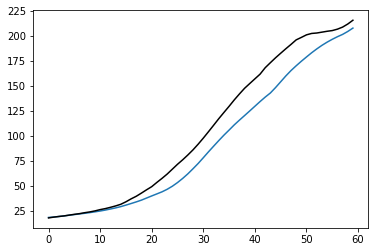

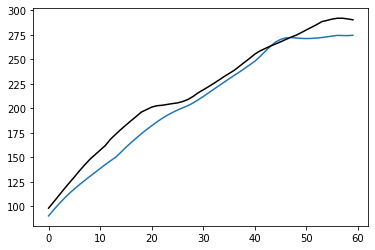

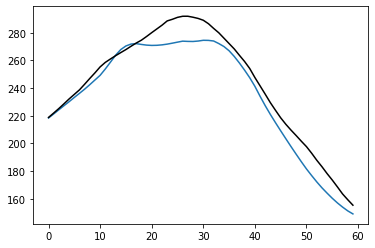

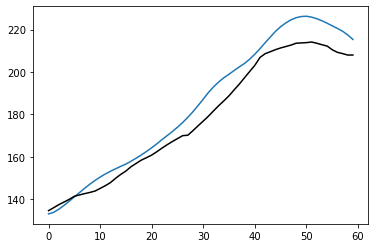

COUNTRY: poland


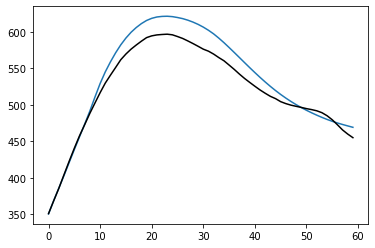

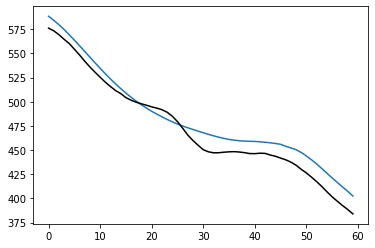

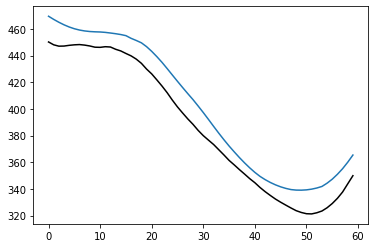

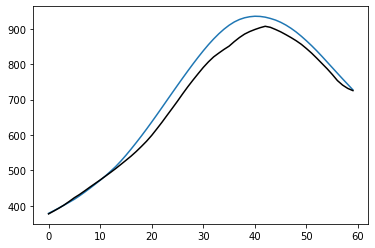

COUNTRY: uk


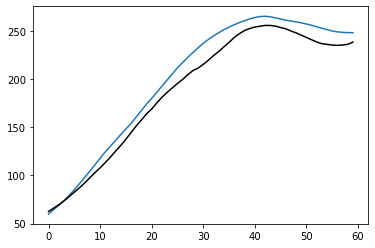

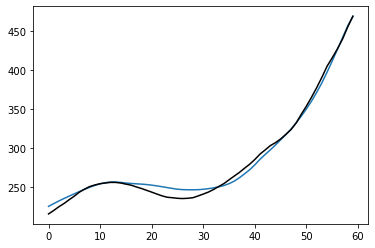

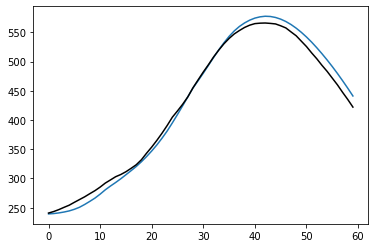

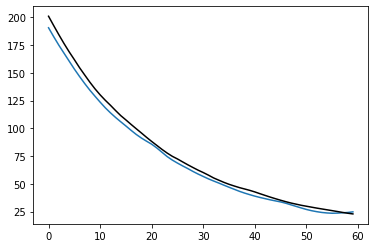

COUNTRY: austria


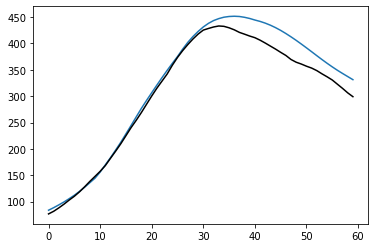

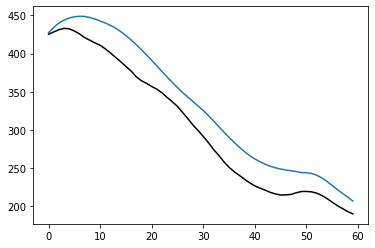

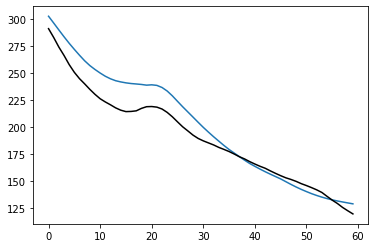

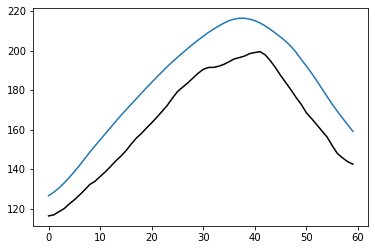

COUNTRY: netherlands


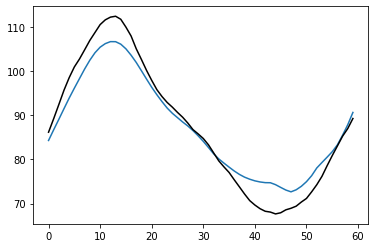

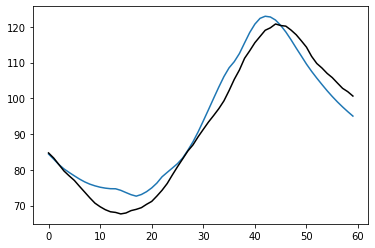

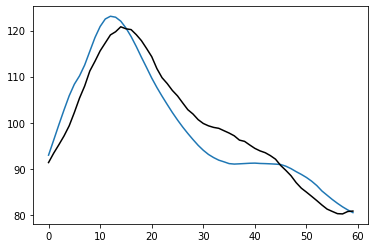

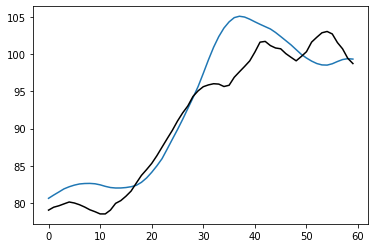

COUNTRY: spain


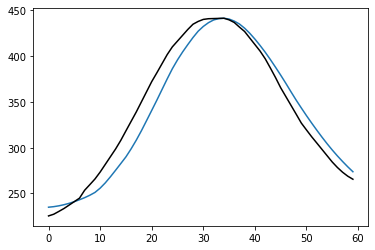

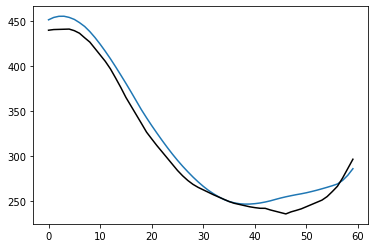

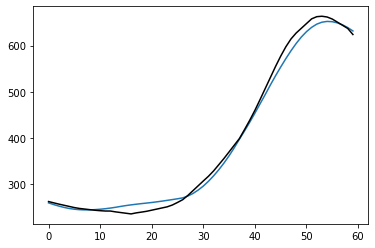

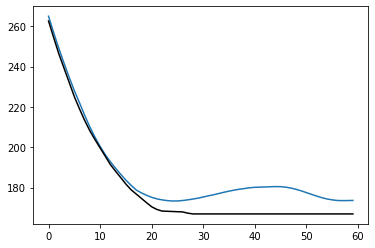

COUNTRY: portugal


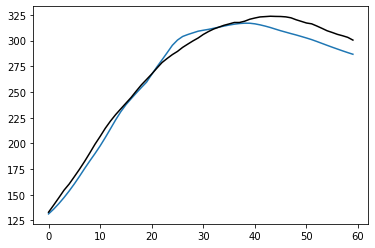

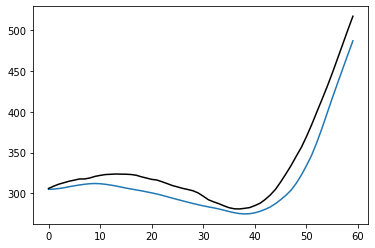

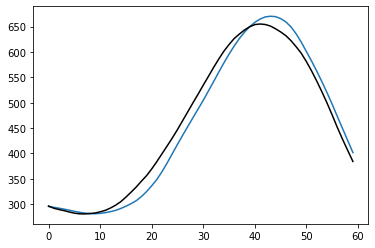

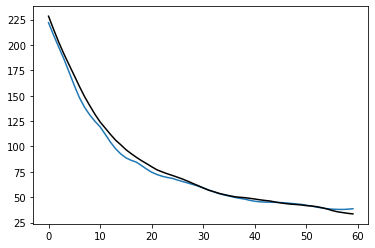

 Root mean squared error for set: 16.23671273397726, R2 score 0.8614406676655669


In [9]:
evaluate_set(countries,reverse_scaler,model,1,target_col="hosp_patients_per_million")

COUNTRY: poland


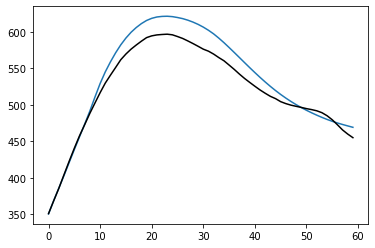

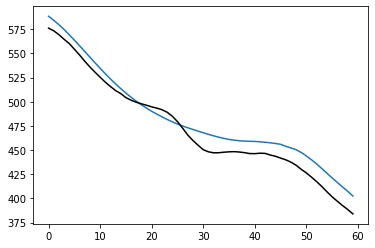

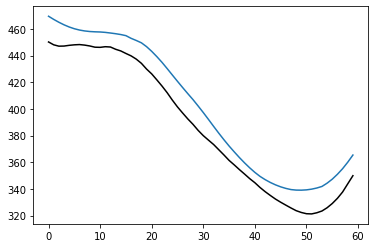

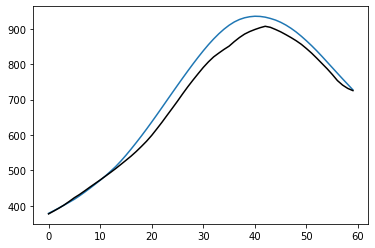

 Root mean squared error for set: 20.635438653707382, R2 score 0.9298387071965131


In [11]:
poland = {
    "poland":countries["poland"]
}



evaluate_set(poland,reverse_scaler,model,1,target_col="hosp_patients_per_million")

In [ ]:
countries["poland"].columns

In [ ]:
data_eval = countries["poland"].iloc[-150:,:].copy()


# evaluation data in form of numpy matrix
data_eval_pred = data_eval.to_numpy()

# setting last 60 steps of target value to zero
data_eval_pred[90:,1] = 0

# in a loop - predicting target values 60 steps ahead
for i in range(60):
    pred_data = data_eval_pred[i:90+i,:]
    value = model.predict(pred_data.reshape(1,90,6))
    data_eval_pred[90+i,1] = value
predictions = data_eval_pred[90:,1]



data_eval = countries["poland"].iloc[-150:,:].copy()


restrictions = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people']

for col in restrictions:
    data_eval[col][-60:]= 0


data_eval_pred = data_eval.copy().to_numpy()

vals = []
for i in range(60):
    pred_data = data_eval_pred[i:90+i,:]
    value = model.predict(pred_data.reshape(1,90,6))
    data_eval_pred[90+i,1] = value

plt.figure()
plt.plot(reverse_scaler.inverse_transform(data_eval_pred[90:,1].reshape(-1, 1)))
plt.plot(reverse_scaler.inverse_transform(predictions.reshape(-1,1)),color="black")
plt.show()


In [ ]:
data_eval